In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def getNormalized(filepath):
    data = np.loadtxt(filepath, skiprows=8)
    return (data[:, 0], data[:,1]/data[0, 1])

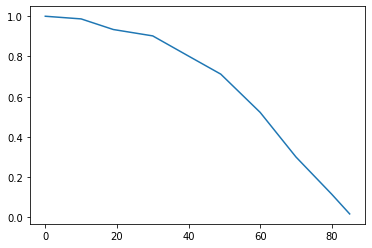

In [20]:
plt.plot(*getNormalized("data/air-glass s transmission.txt"))